# CESM2-LE Initial Condition Memory:  Zonal-mean SHF
 - Use Intake to access CESM2LE data on glade
 - Compute zonal seasonal mean SHF from POP monthly output for all members from 1850-2100
 - Plot Hovmuller of micro-to-total variance vs. time
 - Request at least 50GB on Casper login to run this notebook

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
from os.path import exists
import scipy.stats
from scipy import signal
import cartopy.crs as ccrs
import glob
import dask
import calc
import intake
import pop_tools
from datetime import timedelta
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Create Dask Cluster

In [43]:
# Close out Dask Cluster and release workers:
cluster.close()
client.close()

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='30GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=2:mem=30GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(30) 

In [3]:
cluster

In [4]:
pp_datafile = '/glade/scratch/yeager/cesm2_le/CESM2LE_zmSHF_seas.nc'
if (exists(pp_datafile)):
        print(pp_datafile+' already exists.\n\n')
else:
    print(pp_datafile+' does NOT exist.\n\n')

/glade/scratch/yeager/cesm2_le/CESM2LE_zmSHF_seas.nc does NOT exist.




If CESM2LE post-processed zonal mean SST file already exists, you don't need to do Section 1 (~30 minutes). Go to [Section 2](#section2). 

# Section 1

## Data Intake

In [5]:
# Point to the catalog file
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'

# Open the catalog using intake
col = intake.open_esm_datastore(catalog_file)

/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [6]:
# Find POP assets
oceandata = col.search(component='ocn', variable=['SHF'], frequency='month_1', experiment=['historical','ssp370'])

In [35]:
## Use preprocessor to return seasonal mean
def preproc(ds):
    ds = calc.center_time(ds)
    return ds

In [36]:
%%time
dask.config.set(**{'array.slicing.split_large_chunks': True})

# Create a dataset dictionary from the subsampled catalog
cbc_args = {'data_vars':'minimal'}
dsets = oceandata.to_dataset_dict(
    #xarray_combine_by_coords_kwargs=cbc_args,
    preprocess=preproc)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 45.9 s, sys: 1.39 s, total: 47.3 s
Wall time: 59 s


In [37]:
dsets.keys()

dict_keys(['ocn.ssp370.pop.h.cmip6.SHF', 'ocn.historical.pop.h.smbb.SHF', 'ocn.historical.pop.h.cmip6.SHF', 'ocn.ssp370.pop.h.smbb.SHF'])

In [38]:
dsets['ocn.historical.pop.h.cmip6.SHF'].SHF

<xarray.DataArray 'SHF' (member_id: 50, time: 1980, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(50, 1980, 384, 320), dtype=float32, chunksize=(1, 120, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 1850-01-16 13:00:00.000001 ... 2014-12-16 12:00:00
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Total Surface Heat Flux, Including SW
    units:         watt/m^2
    grid_loc:      2110
    cell_methods:  time: mean

## Data Processing

#### Prepare for Zonal Mean computation:

In [39]:
## Define target lat_aux grid:
lat_aux = xr.DataArray(np.linspace(-90,90,181),dims='lat',attrs={'units':'degrees_north','long_name':'latitude boundaries of zonal mean'})

In [40]:
## Define target region mask
grid_ds = pop_tools.get_grid('POP_gx1v7')
rmask = grid_ds.REGION_MASK
rmask = xr.where((rmask==1) & ((grid_ds['nlon']>=54) & (grid_ds['nlon']<=293)),2,rmask)
rmask = xr.where(rmask==3,2,rmask)
rmask = xr.where(rmask==4,2,rmask)
rmask = xr.where((rmask>=6) & (rmask<=11),1,rmask)
rmask = rmask.where(rmask>0)
rmaskdict = {0:'Global',1:'Atlantic+Arctic',2:'Indo-Pacific'}

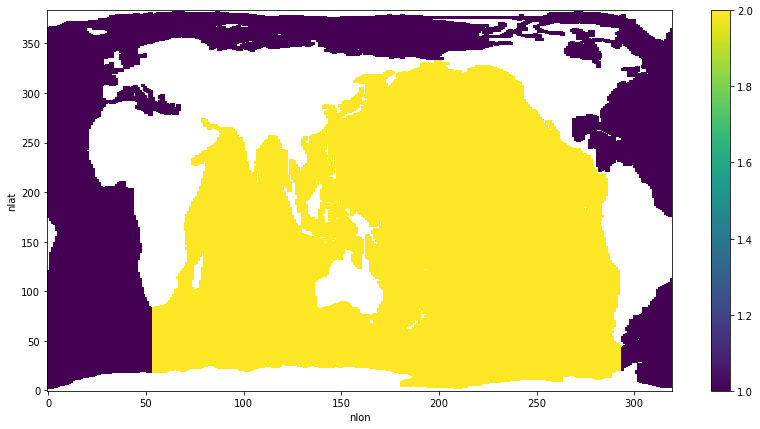

In [41]:
rmask.plot(aspect=2,size=7)

#### Compute Seasonal Zonal-mean SHF:

In [42]:
%%time
da = calc.mon_to_seas2(dsets['ocn.historical.pop.h.cmip6.SHF'].SHF)
cmip6hist_zm = calc.regional_zonal_mean(da,grid_ds,rmask,rmaskdict,lat_axis=lat_aux,lat_field='TLAT',ydim='nlat',xdim='nlon',area_field='TAREA').load()

KeyError: "('rechunk-split-rechunk-merge-12820e18c41f4516ff0fea90059790c1', 1, 1, 36, 0, 0)"

In [15]:
%%time
ds = dsets['ocn.historical.pop.h.smbb.SHF']
smbbhist_zm = calc.regional_zonal_mean(ds.SHF,grid_ds,rmask,rmaskdict,lat_axis=lat_aux,lat_field='TLAT',ydim='nlat',xdim='nlon',area_field='TAREA').load()

CPU times: user 10min 48s, sys: 1min 27s, total: 12min 16s
Wall time: 12min 39s


In [16]:
%%time
ds = dsets['ocn.ssp370.pop.h.cmip6.SHF']
cmip6ssp_zm = calc.regional_zonal_mean(ds.SHF,grid_ds,rmask,rmaskdict,lat_axis=lat_aux,lat_field='TLAT',ydim='nlat',xdim='nlon',area_field='TAREA').load()

CPU times: user 5min 53s, sys: 47.9 s, total: 6min 40s
Wall time: 6min 54s


In [17]:
%%time
ds = dsets['ocn.ssp370.pop.h.smbb.SHF']
smbbssp_zm = calc.regional_zonal_mean(ds.SHF,grid_ds,rmask,rmaskdict,lat_axis=lat_aux,lat_field='TLAT',ydim='nlat',xdim='nlon',area_field='TAREA').load()

CPU times: user 4min 43s, sys: 38.3 s, total: 5min 21s
Wall time: 5min 32s


In [19]:
## Create final Dataset:
work1 = xr.concat([cmip6hist_zm,cmip6ssp_zm],dim='time')
work2 = xr.concat([smbbhist_zm,smbbssp_zm],dim='time')
cesm2le_zm = xr.concat([work1,work2],dim='member_id')
memid = cesm2le_zm.member_id.data
inityear = xr.DataArray([i.split('i')[1].split('p')[0] for i in memid],coords={'member_id':cesm2le_zm.member_id})
memnum = xr.DataArray([i.split('i')[0].split('r')[1].rjust(3,'0') for i in memid],coords={'member_id':cesm2le_zm.member_id})

ds = cesm2le_zm.to_dataset()
ds['inityear'] = inityear
ds['memnum'] = memnum

In [20]:
ds

<xarray.Dataset>
Dimensions:    (member_id: 98, season: 4, time: 251, TLAT_bin: 180, region: 3)
Coordinates:
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r8i1151p1f2'
  * season     (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
  * time       (time) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * TLAT_bin   (TLAT_bin) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * region     (region) <U15 'Global' 'Atlantic+Arctic' 'Indo-Pacific'
Data variables:
    SHF        (region, member_id, season, time, TLAT_bin) float64 nan ... nan
    inityear   (member_id) <U4 '1181' '1231' '1251' ... '1111' '1131' '1151'
    memnum     (member_id) <U3 '010' '010' '010' '010' ... '006' '007' '008'

In [21]:
pp_datafile

'/glade/scratch/yeager/cesm2_le/CESM2LE_zmSHF_seas.nc'

In [22]:
## Save to netcdf:
ds.to_netcdf(pp_datafile)

<a id='section2'></a>

# Section 2

If you skipped Section 1, read in ds for analysis and plotting:

In [ ]:
print('opening '+pp_datafile)
ds = xr.open_dataset(pp_datafile)

In [23]:
ds

<xarray.Dataset>
Dimensions:    (member_id: 98, season: 4, time: 251, TLAT_bin: 180, region: 3)
Coordinates:
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r8i1151p1f2'
  * season     (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
  * time       (time) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * TLAT_bin   (TLAT_bin) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * region     (region) <U15 'Global' 'Atlantic+Arctic' 'Indo-Pacific'
Data variables:
    SHF        (region, member_id, season, time, TLAT_bin) float64 nan ... nan
    inityear   (member_id) <U4 '1181' '1231' '1251' ... '1111' '1131' '1151'
    memnum     (member_id) <U3 '010' '010' '010' '010' ... '006' '007' '008'

In [24]:
# Print summary of initialization years in dataset
iyear = ds.inityear.data
print("Start Year : Members")
for i in set(iyear):
    count = np.count_nonzero(iyear==i)
    print(i+" : "+str(count).zfill(3))

Start Year : Members
1041 : 001
1301 : 020
1151 : 001
1141 : 001
1051 : 001
1091 : 001
1071 : 001
1181 : 001
1011 : 001
1111 : 001
1131 : 001
1281 : 020
1101 : 001
1251 : 020
1081 : 001
1001 : 001
1231 : 020
1061 : 001
1121 : 001
1161 : 001
1031 : 001
1021 : 001


## Guide to Micro and Macro Ensembles:
  - 20-member micro ensembles referred to by start year: 1231, 1251, 1281, 1301
  - 10-member "macro1a" ensemble, initialized: 1001, 1021, 1041, 1061, 1081, 1101, 1121, 1141, 1161, 1181
  - 10-member "macro1b" (MOAR) ensemble, initialized: 1011, 1031, 1051, 1071, 1091, 1111, 1131, 1151, 1171, 1191
  - 10-member "macro2" ensemble (CMIP6 contribution):  b.e21.BHIST.f09_g17.CMIP6-historical.{001-010}


## Decomposition of Ensemble Variance:

Following Singh et al. (2021, in review), decompose CESM2LE ensemble variance for variable X as follows: 
$$ 
\sigma^{2}_{X} = \sigma^{2}_{X,ocn} + \sigma^{2}_{X,atm} + \epsilon 
$$ 
where "ocn" quantifies spread between micro ensembles (due to different ocean initial conditions), and "atm" quantifies spread within micro ensembles (due to perturbed atmospheric initial conditions). Variance within micro ensembles is computed as the average ensemble variance (with p=4, m=20):
$$ 
\sigma^{2}_{X,atm} = \frac{1}{p}\sum_{k=1}^{p}\frac{\sum_{j=1}^{m}(X_{k,j}-\overline{X_{k}})^2}{m-1}
$$ 
Variance across micro ensembles is computed as:
$$ 
\sigma^{2}_{X,ocn} = \frac{\sum_{k=1}^{p}(\overline{X_{k}}-\overline{X})^2}{p-1}
$$ 
where $\overline{X}$ is the mean over the full (80 member) ensemble. The fraction of ensemble variance attributable to ocean initial conditions is then:
$$ 
\chi_{ocn}(t) = \frac{\sigma^{2}_{X,ocn}(t)}{\sigma^{2}_{X}(t)}
$$ 

In [25]:
# Compute sig2_atm, sig2_ocn:
plist = ['1231','1251','1281','1301']
varlist = []
meanlist = []
iyear = ds.inityear.data
for p in plist:
    memind = np.nonzero(iyear==p)
    #print(ds.isel(member_id=memind[0]).inityear.data)
    var = ds.SHF.isel(member_id=memind[0]).var(dim='member_id')
    mean = ds.SHF.isel(member_id=memind[0]).mean(dim='member_id')
    varlist.append(var)
    meanlist.append(mean)
sig2_atm = xr.concat(varlist,dim='p').mean('p')
sig2_ocn = xr.concat(meanlist,dim='p').var('p')

For denominator, keep only the 4 20-member micro ensemble members (80 members total):

In [26]:
iyear = ds.inityear.data
memind = np.nonzero((iyear=='1231') | (iyear=='1251') | (iyear=='1281') | (iyear=='1301'))
da_micros = ds.SHF.isel(member_id=memind[0])
sig2_tot = da_micros.var(dim='member_id')

In [27]:
# Compute chi_ocn
chi_ocn = (sig2_ocn/sig2_tot).rename("Chi_ocn")

Apply low-pass filter:

In [28]:
def lpf_anndata(dat, period=10):
    fs=1/(365*24*3600)        # 1 year in Hz (sampling frequency)
    nyquist = fs / 2          # 0.5 times the sampling frequency
    cutoff = fs/period            # cutoff frequency
    cutoff = cutoff/nyquist   # as fraction of nyquist  
    print('cutoff= ',(1/(cutoff*nyquist))/(365*24*3600),' years') 
    filtsos = signal.butter(4, cutoff, 'lowpass', output='sos') #low pass filter
    filtb, filta = signal.butter(4, cutoff, 'lowpass')
    dat_out = xr.apply_ufunc(signal.sosfiltfilt, filtsos,dat.fillna(0),kwargs={'padtype':'even','axis':0}).where(dat.notnull())
    return dat_out

In [29]:
chi_ocn_lpf = lpf_anndata(chi_ocn.transpose('time','season','region','TLAT_bin'),period=20)

cutoff=  20.0  years


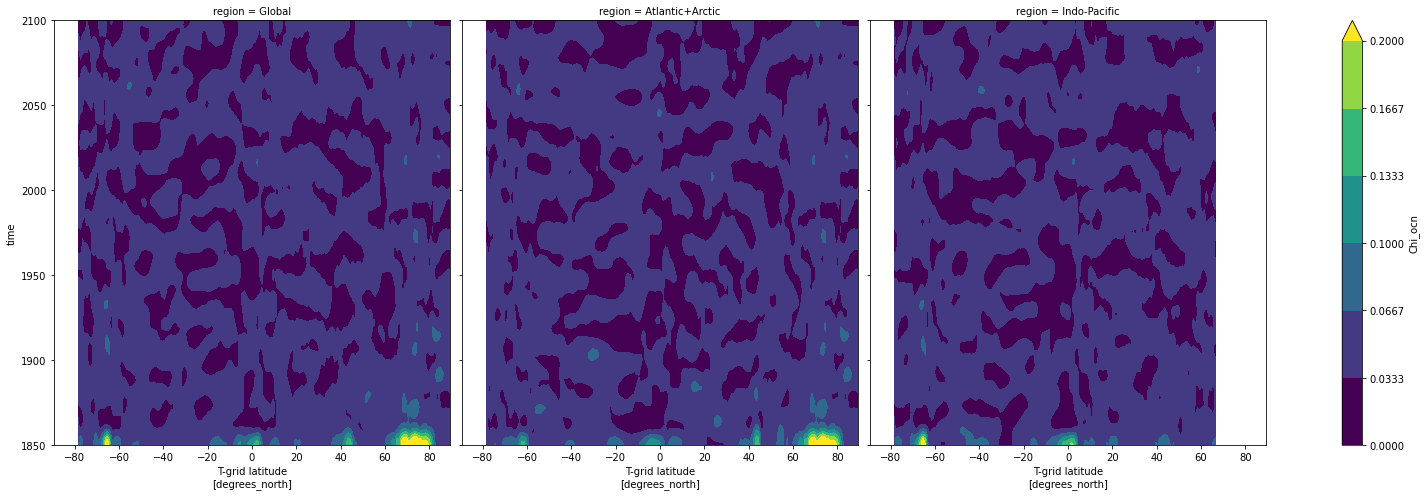

In [34]:
#fig, axes = plt.subplots(ncols=3)
chi_ocn_lpf.isel(season=2).plot.contourf(col='region',vmin=0,vmax=0.2,size=7)
#chi_ocn_lpf.plot.contour(col='region',levels=[0.075],size=7,colors='r')

## Compute bootstrapped significance

In [ ]:
import xskillscore as xs

Resample 80-member pool (with replacement), to generate 100 different synthetic 20-member "micro" ensembles:

In [ ]:
%%time
iterations = 100
ens_size = 20
da_micros_r = xs.resample_iterations_idx(da_micros, iterations, 'member_id', dim_max=ens_size).rename({'iteration':'micro'}).chunk().persist()

In [ ]:
da_micros_r

Now, resample again to generate 500 different 4-micro combinations:

In [ ]:
da_micros_rr = xs.resample_iterations(da_micros_r, 500, 'micro', dim_max=4)

In [ ]:
da_micros_rr

Compute resampled distributions of sig2_atm, sig2_ocn, and chi_ocn:

In [ ]:
%%time
sig2_atm_r = da_micros_rr.var(dim='member_id').mean('micro').load()
sig2_ocn_r = da_micros_rr.mean(dim='member_id').var('micro').load()
sig2_tot_r = da_micros_rr.var(dim=['member_id','micro']).load()
chi_ocn_r = (sig2_ocn_r/sig2_tot_r).rename("Chi_ocn_r")

In [ ]:
chi_ocn_r_lpf = lpf_anndata(chi_ocn_r.transpose('time','region','TLAT_bin','iteration'),period=20)

In [ ]:
# Plot with bootstrapped significance
pval = (chi_ocn_r_lpf > chi_ocn_lpf).sum('iteration')/chi_ocn_r_lpf['iteration'].size
clevs = np.arange(0,9)*0.025


g = chi_ocn_lpf.plot.contourf(col='region',size=7,levels=clevs,cmap='viridis')
for i, ax in enumerate(g.axes.flat):
    pval.isel(region=i).plot.contour(ax=ax,levels=[0.05],colors=['white'])
    if (i>0): ax.set_ylabel('')